In [6]:
# The script is used to integrate data between monkey cortex and mouse cortex data
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
#suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
#suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
#suppressMessages(library(harmony))
#suppressMessages(library(scrattch.hicat))
# suppressMessages(library(clusterProfiler))
# suppressMessages(library(GO.db))
# suppressMessages(library(biomaRt))
# suppressMessages(library(GSA))
#suppressMessages(library(eulerr))
#suppressMessages(library(enrichplot))
#suppressMessages(library(clusterProfiler))
#suppressMessages(library(org.Hs.eg.db))
#suppressMessages(library(scales))
#library(class)


In [7]:
outdir='/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/3area_compare_240123/compare_to_nearby/data'
integrateSeurat=readRDS(paste0(outdir, "/4area_compare_seurat_ALL_down300.rds"))




In [8]:
integrateSeurat=subset(integrateSeurat,maxPredClass=='Excit_Neuron')


Warning message:
“Removing 12556 cells missing data for vars requested”


In [10]:
#画每个细胞距离
#计算每个人类细胞与最近的十个mouse/macaque细胞的平均距离
library(RANN)
library(sf)

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE



In [11]:

integrateSeurat@meta.data[grep('Insular',(integrateSeurat@meta.data$merge_anno)),]$group='Insular'
integrateSeurat@meta.data[grep('Clastrum',(integrateSeurat@meta.data$merge_anno)),]$group='Claustrum'
integrateSeurat@meta.data[grep('Amygdala',(integrateSeurat@meta.data$merge_anno)),]$group='Amygdala'
#integrateSeurat@meta.data[grep('Putamen',(integrateSeurat@meta.data$merge_anno)),]$group='Putamen'

table(integrateSeurat$group)



 Amygdala Claustrum   Insular 
     5200      6600      5700 

In [12]:
cla=subset(integrateSeurat,group=='Claustrum')
df_cla=cla@reductions$umap@cell.embeddings
df_cla=data.frame(df_cla)

pbmc=subset(integrateSeurat,group=='Insular')
df_insu=pbmc@reductions$umap@cell.embeddings
df_insu=data.frame(df_insu)

d=nn2(data=df_insu,query = df_cla,k=10)
df_raw=d$nn.idx
df=df_raw

In [13]:
df_sum=data.frame()
for(i in c(1:nrow(df_raw))){
    vec=pbmc@meta.data$SuperCluster[df_raw[i,]]
    element_counts <- table(vec)  
    most_common_element <- names(element_counts)[which.max(element_counts)]  
    num=as.numeric(element_counts[most_common_element])
    df_sum=rbind(df_sum,c(most_common_element[1],num[1]))
    }
head(df_sum)


,X.GLUT_L2.3.IT.,X.10.
,<chr>,<chr>
1,GLUT_L2/3 IT,10
2,GLUT_L6b,10
3,GLUT_L6 IT,10
4,GLUT_L5/6 IT Car3,9
5,GLUT_L5/6 IT Car3,9
6,GLUT_L5 IT,7


In [14]:

rownames(df_sum)=colnames(cla)
df_sum$SuperCluster=cla$SuperCluster
colnames(df_sum)=c('Insular_anno','num','SuperCluster')
#过滤！！！
#df_sum=df_sum[df_sum$num>5,]
df_sum_re=df_sum[,c('Insular_anno','SuperCluster')]


In [15]:
df_sum_re_sum=df_sum_re[!duplicated(df_sum_re),]
df_sum_re_sum$Freq=0
for(i in c(1:nrow(df_sum_re_sum))){
    df_sum_re_sum[i,]$Freq=nrow(df_sum_re[df_sum_re$Insular_anno==df_sum_re_sum[i,]$Insular_anno &
                                          df_sum_re$SuperCluster==df_sum_re_sum[i,]$SuperCluster ,])
}

df_sum_re_sum$subject=c(1:nrow(df_sum_re_sum))

df_sum_re_sum1 <- transform(df_sum_re_sum,
                          Insular_anno = factor(Insular_anno),
                          SuperCluster = factor(SuperCluster))

df_sum_re_sum1_re=df_sum_re_sum1[,c('Insular_anno','Freq','subject')]
colnames(df_sum_re_sum1_re)=c('compare_anno','Freq','subject')
df_sum_re_sum1_re$anno='Insular'
df_sum_re_sum1_re1=df_sum_re_sum1[,c('SuperCluster','Freq','subject')]
colnames(df_sum_re_sum1_re1)=c('compare_anno','Freq','subject')
df_sum_re_sum1_re1$anno='Clastrum'
df_sum_re_sum1_re_all=rbind(df_sum_re_sum1_re,df_sum_re_sum1_re1)


In [16]:
df_sum_re_sum1_re1

,compare_anno,Freq,subject,anno
,<fct>,<dbl>,<int>,<chr>
6103-1_CELL1310_N2,GLUT_GNB4-,406,1,Clastrum
6103-1_CELL1474_N2,GLUT_VENO,541,2,Clastrum
6103-1_CELL62_N2,GLUT_GNB4-,1063,3,Clastrum
6103-1_CELL2140_N1,GLUT_GNB4+,3140,4,Clastrum
6103-1_CELL2495_N1,GLUT_GNB4-,84,5,Clastrum
6103-1_CELL27_N3,GLUT_GNB4+,103,6,Clastrum
6103-1_CELL1689_N1,GLUT_GNB4-,157,7,Clastrum
6103-1_CELL2703_N1,GLUT_GNB4-,546,8,Clastrum
6103-1_CELL2679_N1,GLUT_GNB4-,116,9,Clastrum


In [17]:
df_sum_re_sum1_re

,compare_anno,Freq,subject,anno
,<fct>,<dbl>,<int>,<chr>
6103-1_CELL1310_N2,GLUT_L2/3 IT,406,1,Insular
6103-1_CELL1474_N2,GLUT_L6b,541,2,Insular
6103-1_CELL62_N2,GLUT_L6 IT,1063,3,Insular
6103-1_CELL2140_N1,GLUT_L5/6 IT Car3,3140,4,Insular
6103-1_CELL2495_N1,GLUT_L5 IT,84,5,Insular
6103-1_CELL27_N3,GLUT_L2/3 IT,103,6,Insular
6103-1_CELL1689_N1,GLUT_L5/6 NP,157,7,Insular
6103-1_CELL2703_N1,GLUT_L4 IT,546,8,Insular
6103-1_CELL2679_N1,GLUT_L5 ET,116,9,Insular


In [19]:
library(ggalluvial)
library(ggplot2)

In [20]:
df=df_sum_re_sum1_re_all[df_sum_re_sum1_re_all$anno=='Insular',]
df$ratio=df$Freq/sum(df$Freq)
df1=df[order(df$compare_anno),]
df1 %>% group_by(compare_anno) %>% summarise(all=sum(ratio)*100)

compare_anno,all
<fct>,<dbl>
GLUT_L2/3 IT,8.227273
GLUT_L4 IT,8.590909
GLUT_L5 ET,1.803030
GLUT_L5 IT,1.272727
GLUT_L5/6 IT Car3,47.893939
GLUT_L5/6 NP,2.954545
GLUT_L6 CT,4.681818
GLUT_L6 IT,16.272727
GLUT_L6b,8.303030


In [21]:
df_col=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_0105/post_analysis/data/color_supercluster_all_insu.csv')

col=df_col$col
names(col)=df_col$X
col

GLUT_GNB4-        GLUT_GNB4+         GLUT_VENO        GABA_PVALB 
        "#E41A1C"         "#377EB8"         "#4DAF4A"         "#984EA3" 
         GABA_SST        GABA_LAMP5   GABA_LAMP5_LHX6          GABA_VIP 
        "#FF7F00"         "#FFFF33"         "#A65628"         "#F781BF" 
        GABA_RELN          GABA_CHC             Oligo        Astrocytes 
        "#999999"         "#66C2A5"         "#FC8D62"         "#8DA0CB" 
        GABA_DRD2         Microglia               OPC        Endotheial 
        "#E78AC3"         "#A6D854"         "#FFD92F"         "#E5C494" 
       GLUT_L5 ET      GLUT_L2/3 IT GLUT_L5/6 IT Car3        GLUT_L5 IT 
        "#8DD3C7"         "#FFFFB3"         "#BEBADA"         "#FB8072" 
       GLUT_L6 IT        GLUT_L6 CT        GLUT_L4 IT          GLUT_L6b 
        "#80B1D3"         "#FDB462"         "#B3DE69"         "#FCCDE5" 
     GLUT_L5/6 NP 
        "#D9D9D9"

In [22]:
sub=df_sum_re_sum1_re_all[df_sum_re_sum1_re_all$anno=='Insular',]
sub$ratio=sub$Freq/sum(sub$Freq)
sub=sub %>% group_by(compare_anno) %>% summarise(sum=sum(ratio))
sum(sub$sum)
sub

[1] 1

compare_anno,sum
<fct>,<dbl>
GLUT_L2/3 IT,0.08227273
GLUT_L4 IT,0.08590909
GLUT_L5 ET,0.01803030
GLUT_L5 IT,0.01272727
GLUT_L5/6 IT Car3,0.47893939
GLUT_L5/6 NP,0.02954545
GLUT_L6 CT,0.04681818
GLUT_L6 IT,0.16272727
GLUT_L6b,0.08303030


In [23]:
df_sum_re_sum1_re_all

,compare_anno,Freq,subject,anno
,<fct>,<dbl>,<int>,<chr>
6103-1_CELL1310_N2,GLUT_L2/3 IT,406,1,Insular
6103-1_CELL1474_N2,GLUT_L6b,541,2,Insular
6103-1_CELL62_N2,GLUT_L6 IT,1063,3,Insular
6103-1_CELL2140_N1,GLUT_L5/6 IT Car3,3140,4,Insular
6103-1_CELL2495_N1,GLUT_L5 IT,84,5,Insular
6103-1_CELL27_N3,GLUT_L2/3 IT,103,6,Insular
6103-1_CELL1689_N1,GLUT_L5/6 NP,157,7,Insular
6103-1_CELL2703_N1,GLUT_L4 IT,546,8,Insular
6103-1_CELL2679_N1,GLUT_L5 ET,116,9,Insular


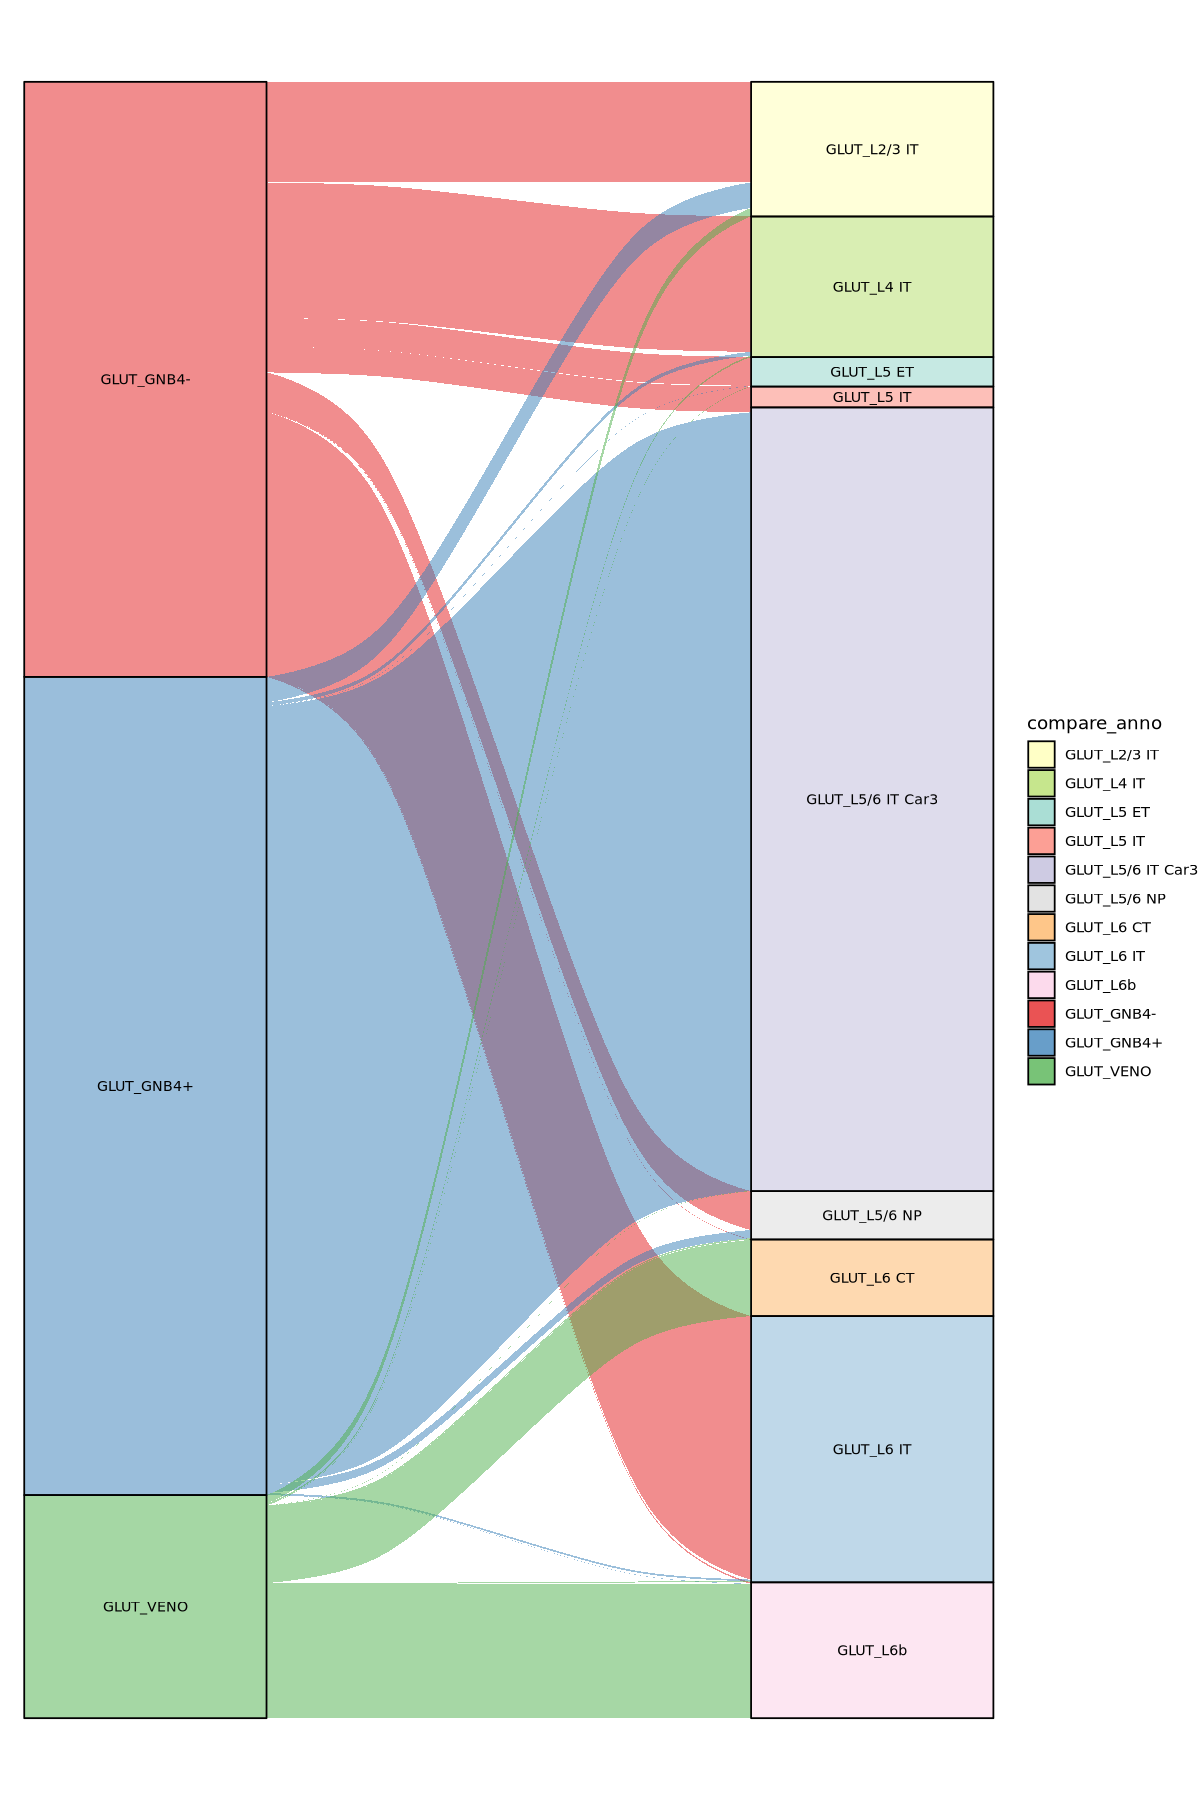

In [24]:
options(repr.plot.width=10, repr.plot.height=15)
gp=ggplot(df_sum_re_sum1_re_all,
       aes(x = anno, stratum = compare_anno, alluvium = subject,
           y = Freq,
           fill = compare_anno, label = compare_anno)) +
  scale_x_discrete(expand = c(.1, .1)) +
  geom_flow() +
  geom_stratum(alpha = .5) +
  geom_text(stat = "stratum", size = 3) +
  theme(legend.position = "none") +
  theme_void()+scale_fill_manual(values = col)
gp

In [25]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/river_plot.pdf", width=10, height=15)
gp
dev.off()



png 
  2

In [1]:
meta=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/Insular_renew_1016/batch_normalize_renew_240115/dif_res_anno/final_anno/46cl_240122_Cluster_Supercluster_res11_meta.csv')
meta=subset(meta,maxPredClass=='Excit_Neuron')


In [4]:
meta=meta[,c('SuperCluster','Cluster')]
meta$num=1
sum_df=meta %>% group_by(SuperCluster) %>% summarise(SuperCluster_num=sum(num))
sum_df$all=sum(sum_df$SuperCluster_num)
sum_df$ratio=sum_df$SuperCluster_num/sum_df$all
sum_df$Cluster='1'


In [7]:
sum_df

SuperCluster,SuperCluster_num,all,ratio,Cluster
<chr>,<dbl>,<dbl>,<dbl>,<chr>
GLUT_L2/3 IT,15137,39798,0.38034575,1
GLUT_L4 IT,8581,39798,0.21561385,1
GLUT_L5 ET,701,39798,0.01761395,1
GLUT_L5 IT,3250,39798,0.08166240,1
GLUT_L5/6 IT Car3,2171,39798,0.05455048,1
GLUT_L5/6 NP,535,39798,0.01344289,1
GLUT_L6 CT,2565,39798,0.06445047,1
GLUT_L6 IT,4910,39798,0.12337303,1
GLUT_L6b,1948,39798,0.04894718,1


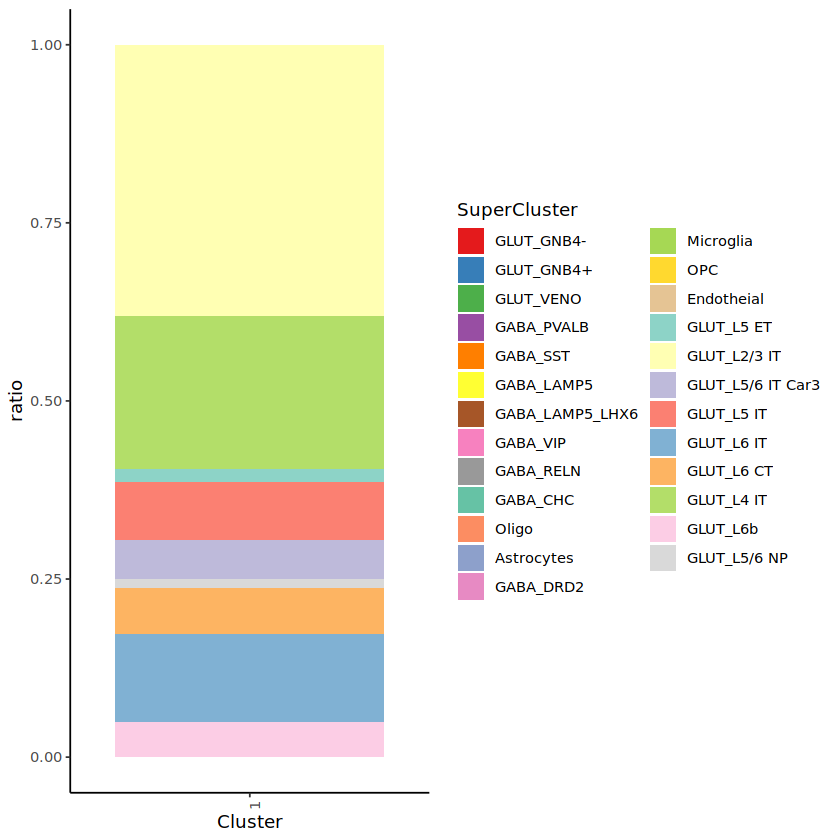

In [9]:
gp=ggplot(data = sum_df, aes(x = Cluster, y = ratio, fill = SuperCluster)) +
 geom_bar(stat = "identity", position = "stack")+theme_classic()+
scale_fill_manual(values = col)+ theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))
gp

In [10]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/area_compare_240118/river_plot1.pdf", width=7, height=15)
gp
dev.off()


png 
  2